<a href="https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/04_Intro_to_Time_Series_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

created by Ignacio Oguiza - email: oguiza@gmail.com

## Purpose 😇

The purpose of this notebook is to show you how you can create a simple, end-to-end, state-of-the-art **time series regression** model using **fastai** and **timeseriesAI** with raw data.

Bear in mind that time series regression is equivalent to **time series forecasting** for a single step ahead. In both cases, what we want the system to do is to assign a value to a given time series pattern.

## Import libraries 📚

In [1]:
stable = True # True: latest version, False: stable version

import sys
ISCOLAB = 'google.colab' in sys.modules
if ISCOLAB:
    if stable: 
        !pip install tsai -q
    else:
        !pip install git+https://github.com/timeseriesAI/tsai.git -q
            
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

tsai       : 0.2.4
fastai     : 2.1.5
fastcore   : 1.3.4
torch      : 1.7.0


## Prepare data 🔢

In [2]:
dsid = 'NATOPS' 
X, y, splits = get_UCR_data(dsid, return_split=False, on_disk=False)

For regression tasks, we need to ensure y is a float. For that purpose, we'll use the `ToFloat()` transform. 

We'll also apply another transform  - `ToNumpyTensor()` - to the y labels to ensure they are casted into a tensor subtype that can be properly displayed when using `dls.show_batch`. 

In [3]:
tfms  = [None, [ToFloat(), ToNumpyTensor()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128])
dsets[0]

(TSTensor(vars:24, len:51), 4.0)

`TSDatasets` identifies this as a regression problem, as the 2nd output (the ys) are floats. That's why the number of classes is set to 1. This is required to be able to correctly use the time series models available in `timesereisAI`.

In [4]:
dsets.c

1

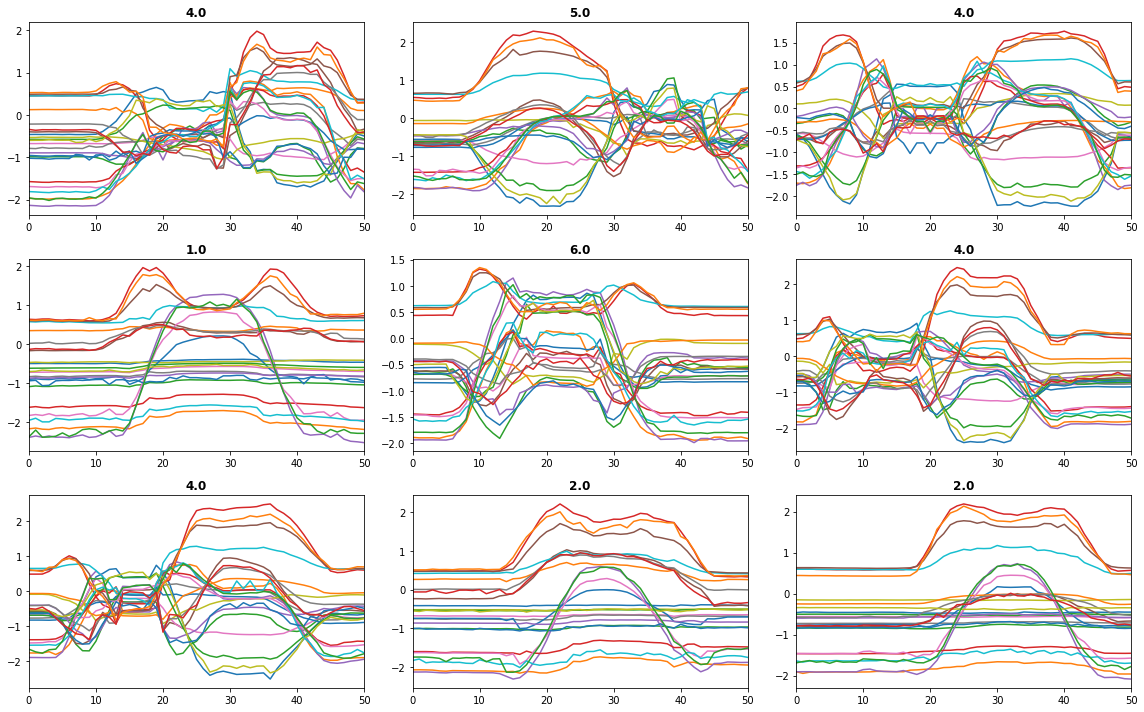

In [5]:
dls.show_batch()

## Build learner 🏗

* Model: we can choose any of the time series models available in `timeseriesAI`. The same ones that work for classification also work for regression. In this case we'll use a state-of-the-art time series model called ` InceptionTime`.
* Loss: since this is a regression problem, we''l use a regression loss (`MSELossFlat`). However, there's not need to pass it to the Learner, as it will automatically infer the required loss.
* Metrics: we'll also choose regression metrics. (`mse` will return the same result as the loss we have selected. Just added it for demo purposes).

In [6]:
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=[mae, mse])

SuggestedLRs(lr_min=0.2754228591918945, lr_steep=0.00363078061491251)

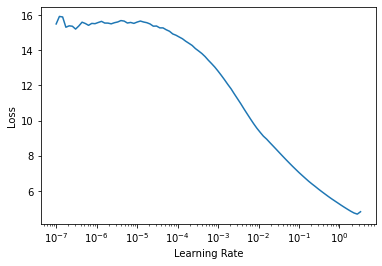

In [7]:
learn.lr_find()

In [8]:
learn.loss_func

FlattenedLoss of MSELoss()

## Train model 🚵🏼‍

epoch,train_loss,valid_loss,mae,mse,time
0,14.274915,15.112356,3.486702,15.112356,00:00
1,14.953782,15.031169,3.474035,15.031169,00:00
2,14.871154,14.989865,3.468882,14.989865,00:00
3,14.189533,14.926322,3.461631,14.926322,00:00
4,13.789836,14.830633,3.451005,14.830633,00:00
5,13.520801,14.706694,3.438370,14.706694,00:00
6,13.121428,14.532705,3.421772,14.532705,00:00
7,12.602882,14.257804,3.395501,14.257804,00:00
8,12.066817,13.801009,3.349962,13.801009,00:00
9,11.574221,13.048508,3.269655,13.048508,00:00


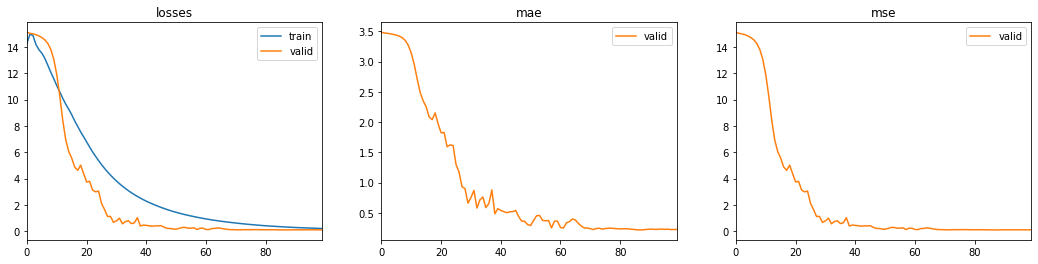

In [9]:
learn.fit_one_cycle(100, lr_max=1e-3)
learn.recorder.plot_metrics()

## Predictions ⎘

In [11]:
valid_preds, valid_targets = learn.get_preds(ds_idx=1)
valid_preds.flatten().data, valid_targets.data

(tensor([3.7703, 5.0020, 6.0284, 0.8333, 3.5315, 2.8809, 2.7526, 2.3839, 2.8170,
         1.0354, 5.0216, 3.9414, 2.4877, 5.1141, 1.8749, 1.1920, 4.8096, 0.6502,
         4.8863, 0.9522, 2.8930, 4.0097, 5.5933, 5.9315, 2.3714, 2.9296, 2.6978,
         0.9772, 1.8776, 4.6022, 2.9900, 3.9207, 4.3128, 4.9796, 4.2679, 5.5830,
         3.8384, 0.8922, 3.2135, 5.7431, 5.1535, 2.5613, 2.2637, 5.1737, 1.0276,
         2.8652, 4.6724, 3.8183, 2.4998, 3.2545, 2.2928, 2.6861, 1.3847, 2.4677,
         0.9271, 2.4401, 1.3577, 0.9259, 5.1638, 1.8561, 4.9097, 6.1943, 1.0459,
         6.1193, 1.9908, 1.9740, 1.2367, 3.1562, 4.9588, 1.9142, 5.8156, 3.7834,
         1.1177, 3.7022, 4.7404, 4.0850, 1.9259, 5.1798, 5.0323, 2.8950, 0.9484,
         3.8553, 4.0077, 5.9068, 2.5396, 6.0177, 2.9635, 5.7630, 6.1505, 4.6146,
         5.0694, 2.7898, 5.0299, 4.1939, 5.4213, 2.4789, 2.0795, 5.9228, 0.9573,
         4.1209, 1.1249, 5.5639, 3.9230, 5.7608, 1.3298, 5.2989, 5.6664, 0.9779,
         2.6910, 5.7851, 1.2

## Summary ✅

As you can see, to use fastai and timeseriesAI to perform a time series regression/ forecasting task is pretty easy. The only thing you need to make sure is that:

* Your data is correctly prepared (with ys as floats)
* Select the right metrics (Learner will automatically select the right loss, unless you want to pass a specific one yourself).